# Clinical Data EDA

## Imports

In [1]:
import sys
sys.path.append("../src")

# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
import missingno as mno
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

#Custom packages
from utils import print_missing_vals, plot_correlation_heatmap, plot_feature_distribution


# settings
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

In [2]:
full_clinical_data =pd.read_csv("../data/train_clinical_data.csv")
full_clinical_without_dummies = full_clinical_data
full_clinical_data = pd.concat([full_clinical_data, pd.get_dummies(full_clinical_data['upd23b_clinical_state_on_medication'], prefix='upd23b_medication')], axis=1)
full_clinical_data = full_clinical_data.drop(['upd23b_clinical_state_on_medication'], axis=1)
clinical_data = full_clinical_data.drop(['patient_id', 'visit_month', 'visit_id'], axis=1)
updrs_data = clinical_data.drop(['upd23b_medication_On', 'upd23b_medication_Off'],axis=1)
peptide_data =pd.read_csv("../data/train_peptides.csv")
protein_data =pd.read_csv("../data/train_proteins.csv")

In [3]:
cleaned_clinical = pd.read_csv("../data/imputed/train_clinical_imputed.csv")
cleaned_clinical = cleaned_clinical.drop('Unnamed: 0', axis=1)

## Beginning EDA

### .info for datasets

In [49]:
full_clinical_data['visit_month'].unique()

array([  0,   3,   6,   9,  12,  18,  24,  30,  36,  42,  48,  54,  60,
        72,  84,  96, 108])

In [4]:
full_clinical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2615 entries, 0 to 2614
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   visit_id               2615 non-null   object 
 1   patient_id             2615 non-null   int64  
 2   visit_month            2615 non-null   int64  
 3   updrs_1                2614 non-null   float64
 4   updrs_2                2613 non-null   float64
 5   updrs_3                2590 non-null   float64
 6   updrs_4                1577 non-null   float64
 7   upd23b_medication_Off  2615 non-null   uint8  
 8   upd23b_medication_On   2615 non-null   uint8  
dtypes: float64(4), int64(2), object(1), uint8(2)
memory usage: 148.2+ KB


In [5]:
peptide_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981834 entries, 0 to 981833
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   visit_id          981834 non-null  object 
 1   visit_month       981834 non-null  int64  
 2   patient_id        981834 non-null  int64  
 3   UniProt           981834 non-null  object 
 4   Peptide           981834 non-null  object 
 5   PeptideAbundance  981834 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 44.9+ MB


In [6]:
protein_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232741 entries, 0 to 232740
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   visit_id     232741 non-null  object 
 1   visit_month  232741 non-null  int64  
 2   patient_id   232741 non-null  int64  
 3   UniProt      232741 non-null  object 
 4   NPX          232741 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 8.9+ MB


### .describe for datasets

In [7]:
full_clinical_data.describe()
# updrs_1 can vary from 0-52
# updrs_2 can vary from 0-52
# updrs_3 can vary from 0-132
# updrs_3 can vary from 0-24

,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_medication_Off,upd23b_medication_On
count,2615.000000,2615.000000,2614.000000,2613.00000,2590.000000,1577.000000,2615.000000,2615.000000
mean,32651.743786,31.190822,7.110559,6.74359,19.421236,1.861763,0.196176,0.296367
std,18535.758700,25.199053,5.525955,6.32323,15.000289,3.022112,0.397179,0.456742
min,55.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,16574.000000,10.500000,3.000000,1.00000,6.000000,0.000000,0.000000,0.000000
50%,29417.000000,24.000000,6.000000,5.00000,19.000000,0.000000,0.000000,0.000000
75%,50611.000000,48.000000,10.000000,10.00000,29.000000,3.000000,0.000000,1.000000
max,65043.000000,108.000000,33.000000,40.00000,86.000000,20.000000,1.000000,1.000000


In [8]:
peptide_data.describe()

,visit_month,patient_id,PeptideAbundance
count,981834.000000,981834.000000,9.818340e+05
mean,26.105061,32603.465361,6.428902e+05
std,22.913897,18605.934422,3.377989e+06
min,0.000000,55.000000,1.099850e+01
25%,6.000000,16566.000000,2.817425e+04
50%,24.000000,29313.000000,7.430830e+04
75%,48.000000,49995.000000,2.213388e+05
max,108.000000,65043.000000,1.787520e+08


In [9]:
protein_data.describe()

,visit_month,patient_id,NPX
count,232741.000000,232741.000000,2.327410e+05
mean,26.099205,32593.881873,2.712077e+06
std,22.874719,18608.479506,2.224155e+07
min,0.000000,55.000000,8.460820e+01
25%,6.000000,16566.000000,2.946440e+04
50%,24.000000,29313.000000,1.135560e+05
75%,48.000000,49995.000000,5.638940e+05
max,108.000000,65043.000000,6.138510e+08


## Missing Data

<AxesSubplot: >

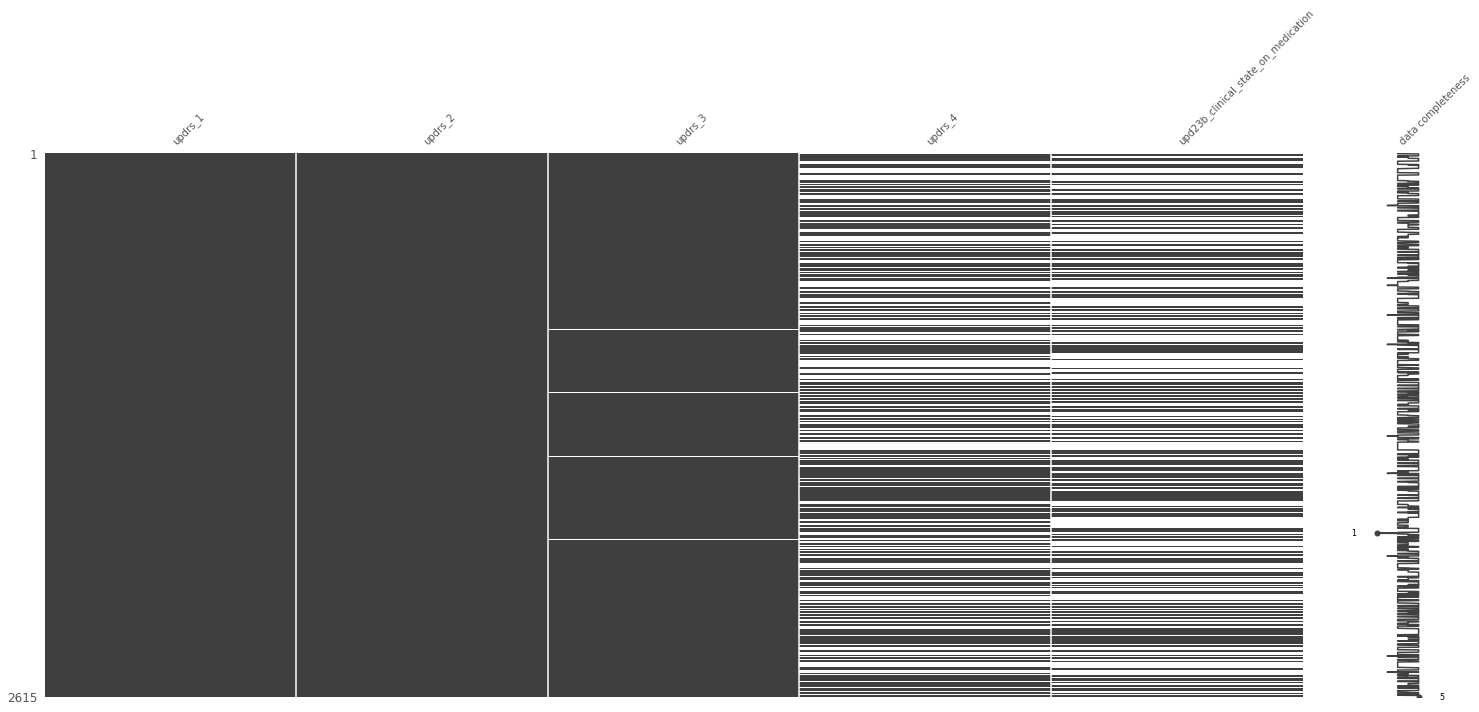

In [37]:
mno.matrix(full_clinical_without_dummies.drop(['visit_id','patient_id','visit_month'], axis=1), labels=True, fontsize=10)

In [38]:
print_missing_vals(full_clinical_without_dummies.drop(['visit_id','patient_id','visit_month'], axis=1), 5)

                                     Total   Percent
upd23b_clinical_state_on_medication   1327  0.507457
updrs_4                               1038  0.396941
updrs_3                                 25  0.009560
updrs_2                                  2  0.000765
updrs_1                                  1  0.000382


Seeing if the missing values in updrs_4 are informative. It would seem that when the updrs_4 values are missing that corresponds to siginificantly lower scores for the other tests. Thus this will be an important feature to include in the model

In [12]:
missing_updrs_4 = clinical_data.loc[clinical_data['updrs_4'].isnull()]
missing_updrs_4[['updrs_1', 'updrs_2', 'updrs_3']].describe()

,updrs_1,updrs_2,updrs_3
count,1037.000000,1037.000000,1027.000000
mean,5.038573,3.878496,11.931840
std,4.252464,4.979755,12.733405
min,0.000000,0.000000,0.000000
25%,2.000000,0.000000,1.000000
50%,4.000000,2.000000,8.000000
75%,7.000000,6.000000,20.000000
max,33.000000,28.000000,68.000000


In [13]:
clinical_data[['updrs_1', 'updrs_2', 'updrs_3']].describe()

,updrs_1,updrs_2,updrs_3
count,2614.000000,2613.00000,2590.000000
mean,7.110559,6.74359,19.421236
std,5.525955,6.32323,15.000289
min,0.000000,0.00000,0.000000
25%,3.000000,1.00000,6.000000
50%,6.000000,5.00000,19.000000
75%,10.000000,10.00000,29.000000
max,33.000000,40.00000,86.000000


## Clinical Data Analysis

In [14]:
# updrs_1 can vary from 0-52
# updrs_2 can vary from 0-52
# updrs_3 can vary from 0-132
# updrs_3 can vary from 0-24

### Clinical Data Correlation

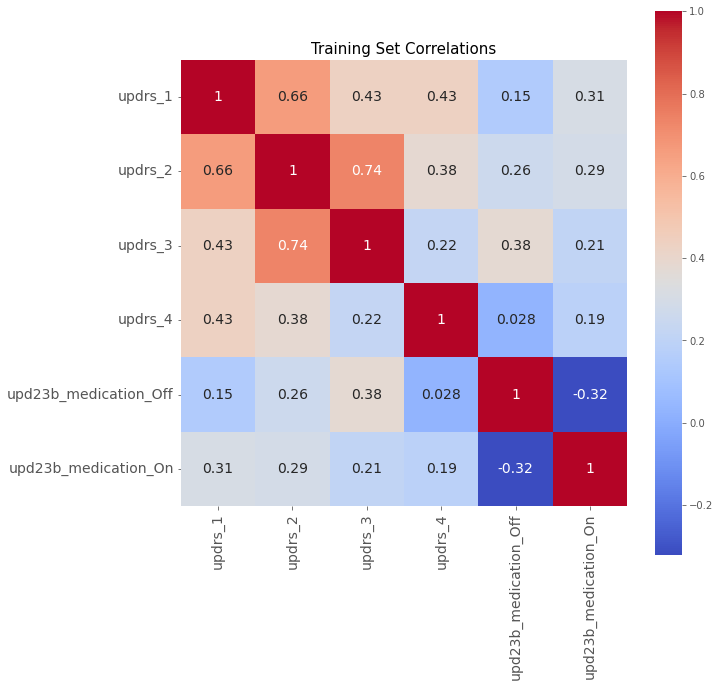

In [15]:
plot_correlation_heatmap(df_train=clinical_data, drop_columns=[], annotate=True, figsize=(10,10))

### Clinical Data Distributions

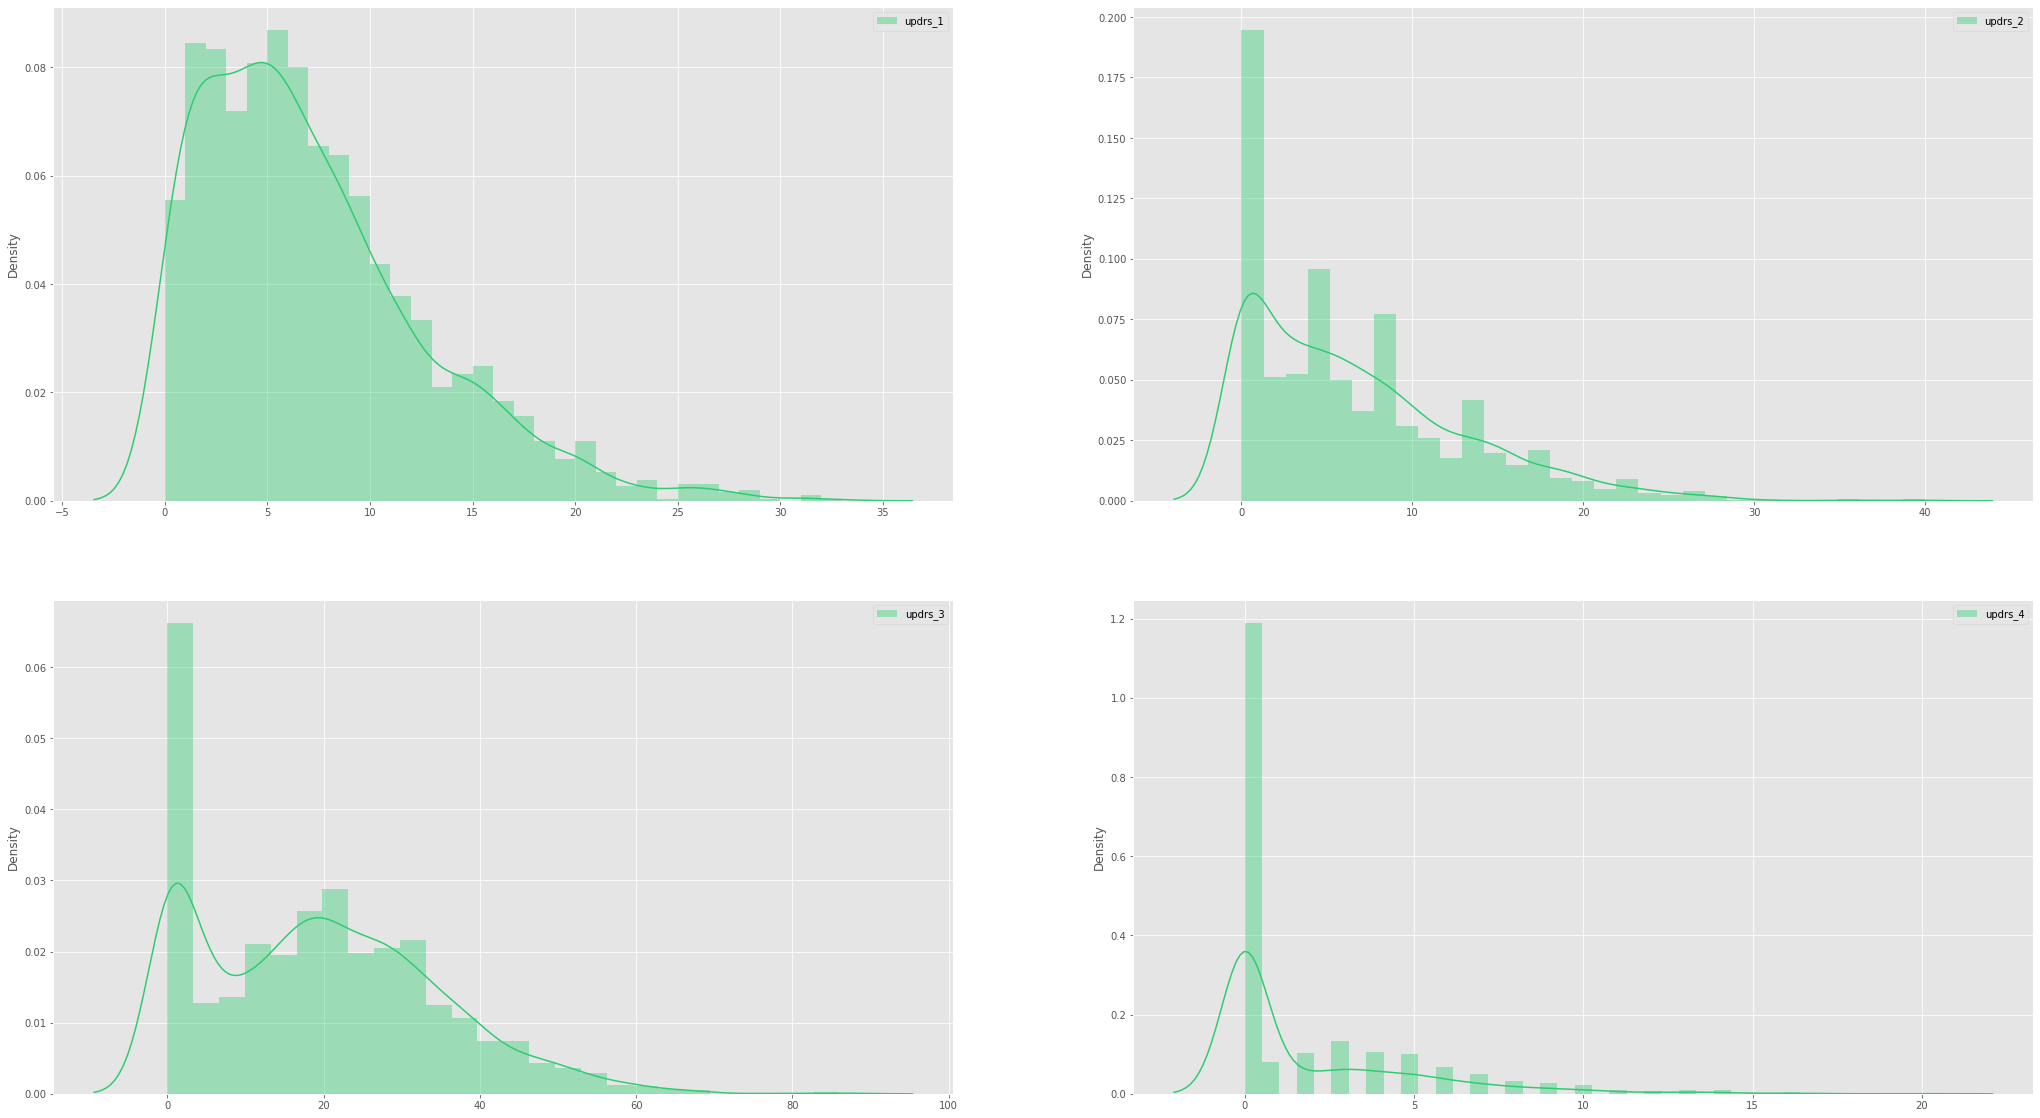

In [16]:
plot_feature_distribution(updrs_data, updrs_data.columns , 2)

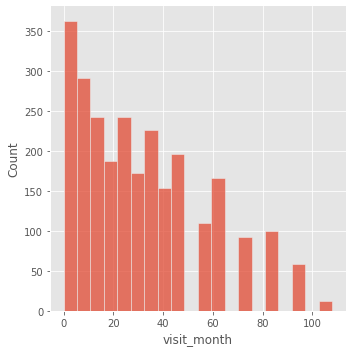

In [46]:
sns.displot(full_clinical_data['visit_month'])

### Clinical Data Dendogram

<AxesSubplot: >

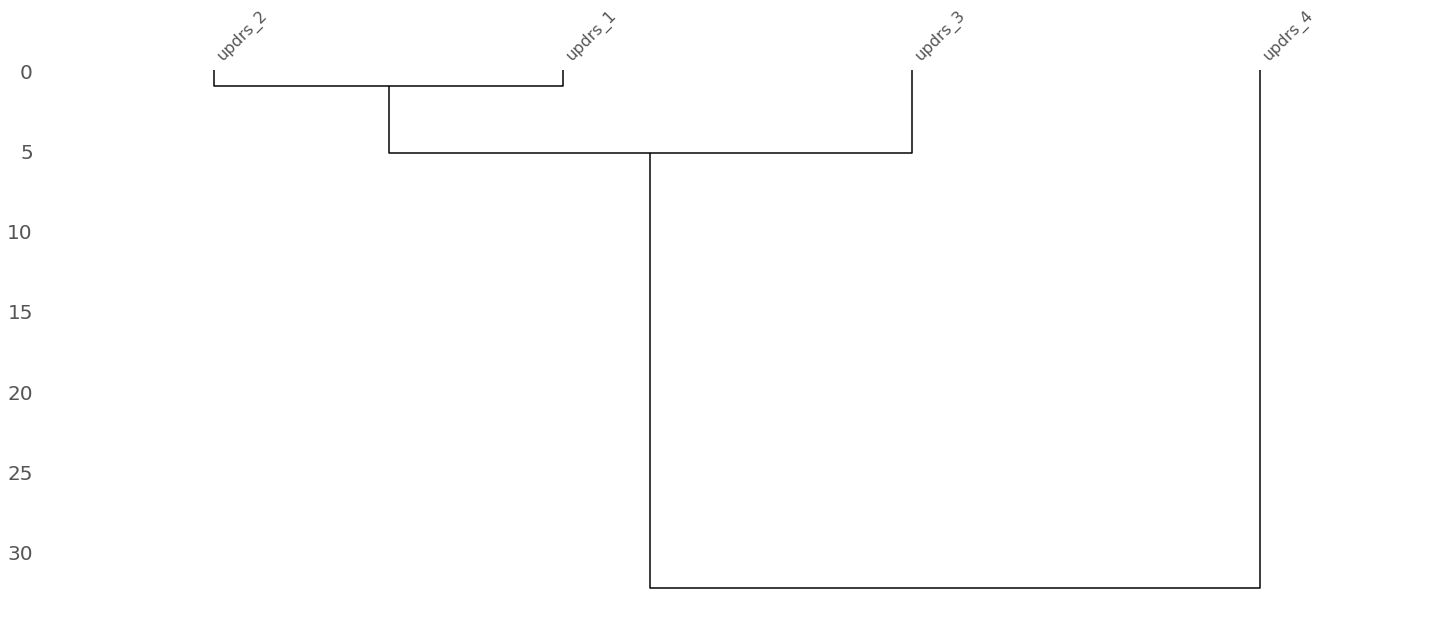

In [17]:
mno.dendrogram(updrs_data)

#### Clinical Pairplot

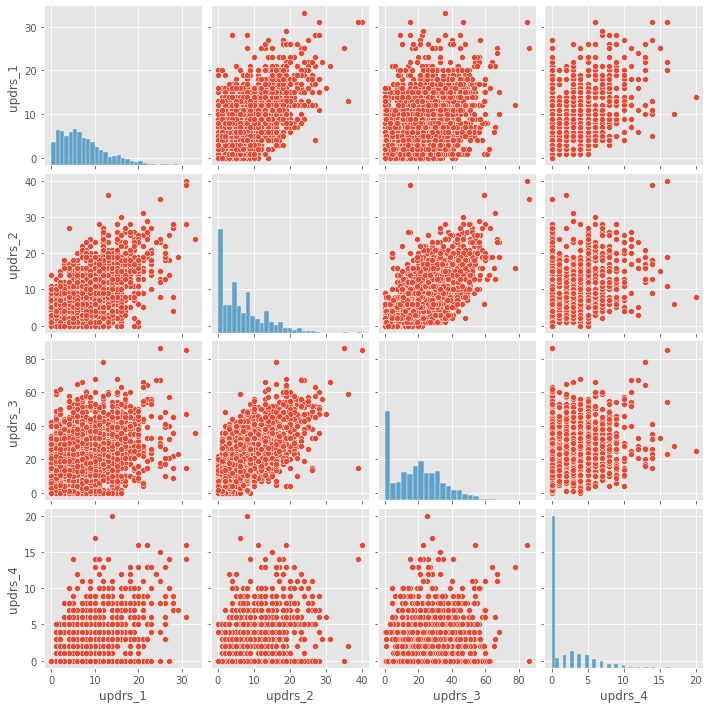

In [18]:
sns.pairplot(full_clinical_data[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']])

### Clinical Data Feature Engineering

In [19]:
# https://www.kaggle.com/competitions/amp-parkinsons-disease-progression-prediction/discussion/388521

In [20]:
keys = ['patient_id']
drop = ['visit_id', 'visit_month'] 
# full_clinical_data.drop(drop, axis=1).groupby(keys).transform(lambda x: x.mean())
# full_clinical_data.drop(drop, axis=1).groupby(keys).transform(lambda x: x.median())
full_clinical_data.drop(drop, axis=1).groupby(keys).transform(lambda x: x.std())
# full_clinical_data.drop(drop, axis=1).groupby(keys).transform(lambda x: x.count())
# full_clinical_data.drop(drop, axis=1).groupby(keys).transform(lambda x: x.sum())

,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_medication_Off,upd23b_medication_On
0,4.610467,5.057363,12.196048,0.000000,0.00000,0.438529
1,4.610467,5.057363,12.196048,0.000000,0.00000,0.438529
2,4.610467,5.057363,12.196048,0.000000,0.00000,0.438529
3,4.610467,5.057363,12.196048,0.000000,0.00000,0.438529
4,4.610467,5.057363,12.196048,0.000000,0.00000,0.438529
...,...,...,...,...,...,...
2610,2.218966,1.804756,4.750940,0.904534,0.48795,0.258199
2611,2.218966,1.804756,4.750940,0.904534,0.48795,0.258199
2612,2.218966,1.804756,4.750940,0.904534,0.48795,0.258199
2613,2.218966,1.804756,4.750940,0.904534,0.48795,0.258199


## Protein Data Analysis

### General Analysis

In [21]:
print(protein_data['UniProt'].unique())
print(len(protein_data['UniProt'].unique()))

['O00391' 'O00533' 'O00584' 'O14498' 'O14773' 'O14791' 'O15240' 'O15394'
 'O43505' 'O60888' 'O75144' 'O75326' 'O94919' 'P00441' 'P00450' 'P00734'
 'P00736' 'P00738' 'P00746' 'P00747' 'P00748' 'P00751' 'P01008' 'P01009'
 'P01011' 'P01019' 'P01023' 'P01024' 'P01031' 'P01033' 'P01034' 'P01042'
 'P01344' 'P01591' 'P01608' 'P01621' 'P01717' 'P01780' 'P01833' 'P01834'
 'P01857' 'P01859' 'P01860' 'P01861' 'P01876' 'P01877' 'P02452' 'P02647'
 'P02649' 'P02652' 'P02655' 'P02656' 'P02671' 'P02675' 'P02679' 'P02747'
 'P02748' 'P02749' 'P02750' 'P02751' 'P02753' 'P02760' 'P02763' 'P02765'
 'P02766' 'P02768' 'P02774' 'P02787' 'P02790' 'P04004' 'P04075' 'P04156'
 'P04180' 'P04196' 'P04207' 'P04211' 'P04216' 'P04217' 'P04275' 'P04406'
 'P04433' 'P05060' 'P05067' 'P05090' 'P05155' 'P05156' 'P05408' 'P05452'
 'P05546' 'P06310' 'P06396' 'P06454' 'P06681' 'P06727' 'P07195' 'P07225'
 'P07333' 'P07339' 'P07602' 'P07711' 'P07858' 'P07998' 'P08123' 'P08133'
 'P08253' 'P08294' 'P08493' 'P08571' 'P08603' 'P086

In [22]:
drop = ['visit_id', 'visit_month','patient_id'] 
group = ['UniProt']
grouped_by_UniProt_protein_data = protein_data.drop(drop, axis=1).groupby(group).mean()
grouped_by_UniProt_protein_data

,NPX
UniProt,
O00391,11641.264435
O00533,511164.883903
O00584,26505.529157
O14498,27305.934884
O14773,17688.295406
...,...
Q9UHG2,229862.538275
Q9UKV8,69924.939658
Q9UNU6,19742.853219


In [23]:
drop = ['visit_id', 'patient_id'] 
group = ['UniProt','visit_month']
gb_month_prot = protein_data.drop(drop, axis=1).groupby(group, as_index=False).mean()
gb_month_prot.to_csv("../data/artificial_data/protein_groupedby_uniprot_month.csv")

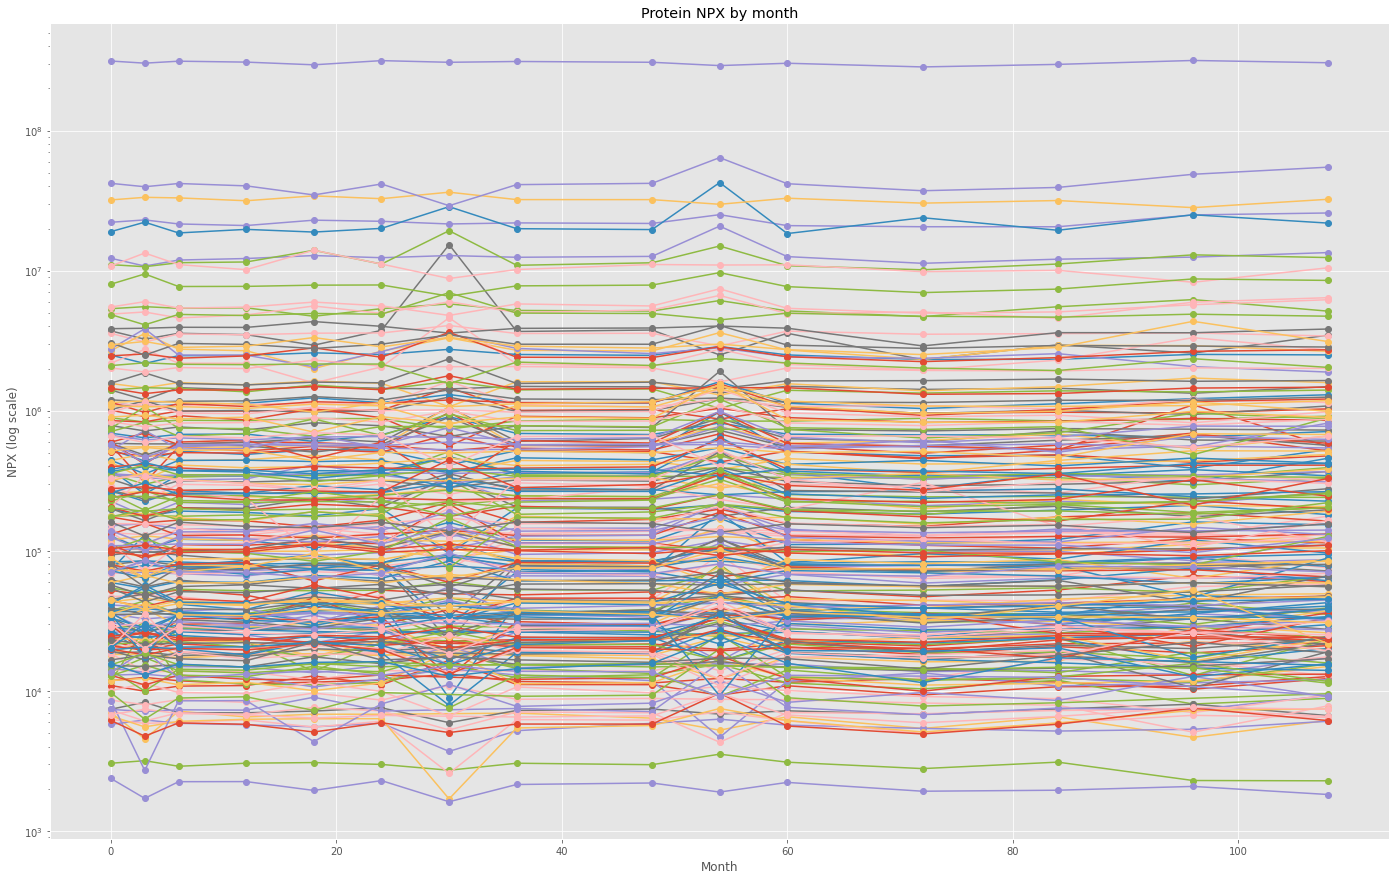

In [24]:
# P02768 is an outlier and ruins the plot
unique_prot = protein_data['UniProt'].unique()
# unique_prot = np.delete(unique_prot, np.where(unique_prot == 'P02768'))

plt.figure(figsize=(30,15))
ax = plt.subplot()
for prot in unique_prot:
    ax.plot(gb_month_prot[gb_month_prot['UniProt'] == prot]['visit_month'], gb_month_prot[gb_month_prot['UniProt'] == prot]['NPX'], label = prot, marker='o')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_title("Protein NPX by month")
ax.set_xlabel("Month")
ax.set_ylabel("NPX (log scale)")
ax.set_yscale('log')

plt.show()

### Missing Data

<AxesSubplot: >

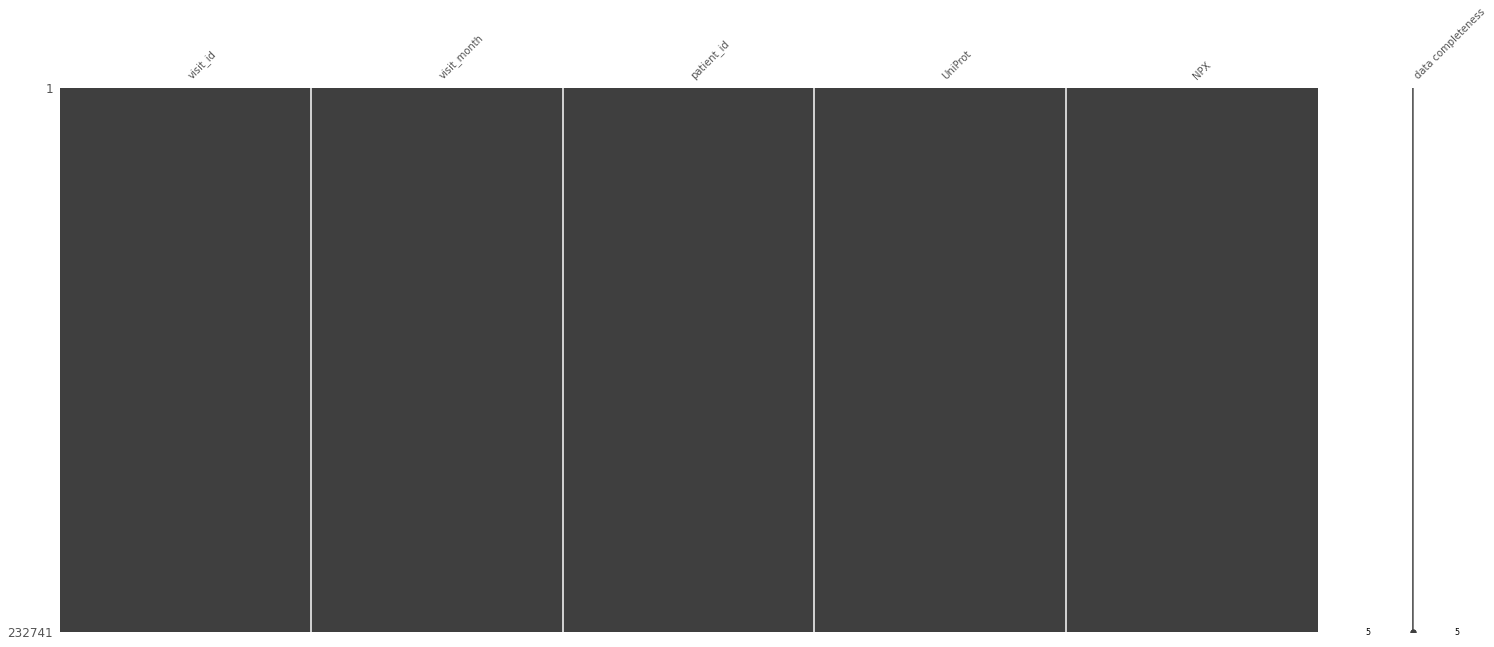

In [25]:
mno.matrix(protein_data, labels=True, fontsize=10)

In [26]:
print_missing_vals(protein_data, 6)

             Total  Percent
visit_id         0      0.0
visit_month      0      0.0
patient_id       0      0.0
UniProt          0      0.0
NPX              0      0.0


### Distribution

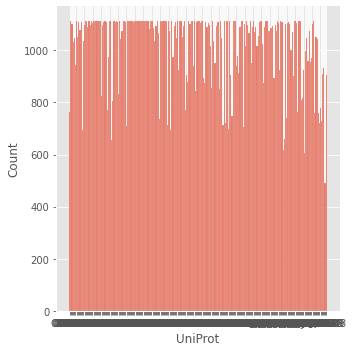

In [48]:
sns.displot(protein_data['UniProt'])

## Peptide Data Analysis

### General Analysis

In [27]:
print(peptide_data['Peptide'].unique())
print(len(peptide_data['Peptide'].unique()))

['NEQEQPLGQWHLS' 'GNPEPTFSWTK' 'IEIPSSVQQVPTIIK'
 'KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK' 'SMEQNGPGLEYR'
 'TLKIENVSYQDKGNYR' 'VIAVNEVGR' 'VMTPAVYAPYDVK' 'VNGSPVDNHPFAGDVVFPR'
 'ELDLNSVLLK' 'HGTC(UniMod_4)AAQVDALNSQKK' 'ALPGTPVASSQPR'
 'LFGGNFAHQASVAR' 'LYQQHGAGLFDVTR' 'VTEPISAESGEQVER' 'AYQGVAAPFPK'
 'QQETAAAETETR' 'THLGEALAPLSK' 'ASGSPEPAISWFR' 'NIINSDGGPYVC(UniMod_4)R'
 'TALASGGVLDASGDYR' 'TQSSLVPALTDFVR' 'ALMSPAGMLR' 'GLYDVVSVLR'
 'SEGLLAC(UniMod_4)GTNAR' 'ILEVVNQIQDEER' 'QALNTDYLDSDYQR'
 'ADDLGKGGNEESTKTGNAGSR' 'TLVVHEKADDLGKGGNEESTK' 'ALYLQYTDETFR'
 'EVGPTNADPVC(UniMod_4)LAK' 'FNKNNEGTYYSPNYNPQSR' 'GAYPLSIEPIGVR'
 'KAEEEHLGILGPQLHADVGDKVK' 'MFTTAPDQVDKEDEDFQESNK'
 'MYYSAVDPTKDIFTGLIGPM(UniMod_35)K' 'NNEGTYYSPNYNPQSR' 'QYTDSTFRVPVER'
 'SVPPSASHVAPTETFTYEWTVPK' 'DKLAAC(UniMod_4)LEGNC(UniMod_4)AEGLGTNYR'
 'ELLESYIDGR' 'LAVTTHGLPC(UniMod_4)LAWASAQAK'
 'RQEC(UniMod_4)SIPVC(UniMod_4)GQDQVTVAMTPR'
 'SEGSSVNLSPPLEQC(UniMod_4)VPDRGQQYQGR' 'SGIEC(UniMod_4)QLWR'
 'TATSEYQTFFNPR' 'MGNFPWQVFT

In [28]:
drop = ['visit_id', 'patient_id','UniProt'] 
group = ['Peptide','visit_month']
gb_month_pep = peptide_data.drop(drop, axis=1).groupby(group, as_index=False).mean()
gb_month_pep.to_csv("../data/artificial_data/peptide_groupedby_peptide_month.csv")

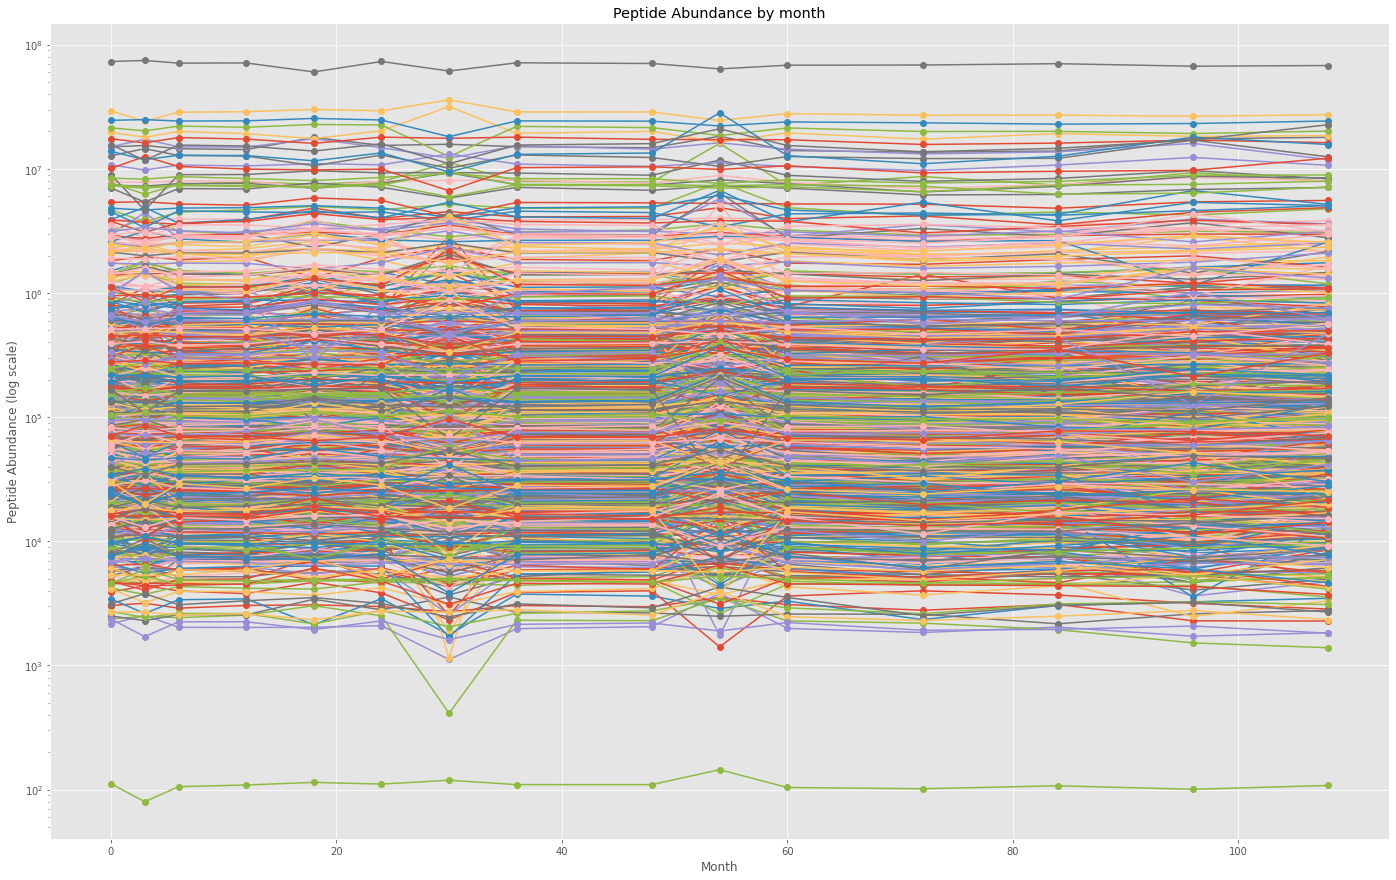

In [29]:
unique_pep = peptide_data['Peptide'].unique()
# unique_prot = np.delete(unique_prot, np.where(unique_prot == 'P02768'))

plt.figure(figsize=(30,15))
ax = plt.subplot()
for pep in unique_pep:
    ax.plot(gb_month_pep[gb_month_pep['Peptide'] == pep]['visit_month'], gb_month_pep[gb_month_pep['Peptide'] == pep]['PeptideAbundance'], label = pep, marker='o')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_title("Peptide Abundance by month")
ax.set_xlabel("Month")
ax.set_ylabel("Peptide Abundance (log scale)")
ax.set_yscale('log')

plt.show()

### Missing Data

<AxesSubplot: >

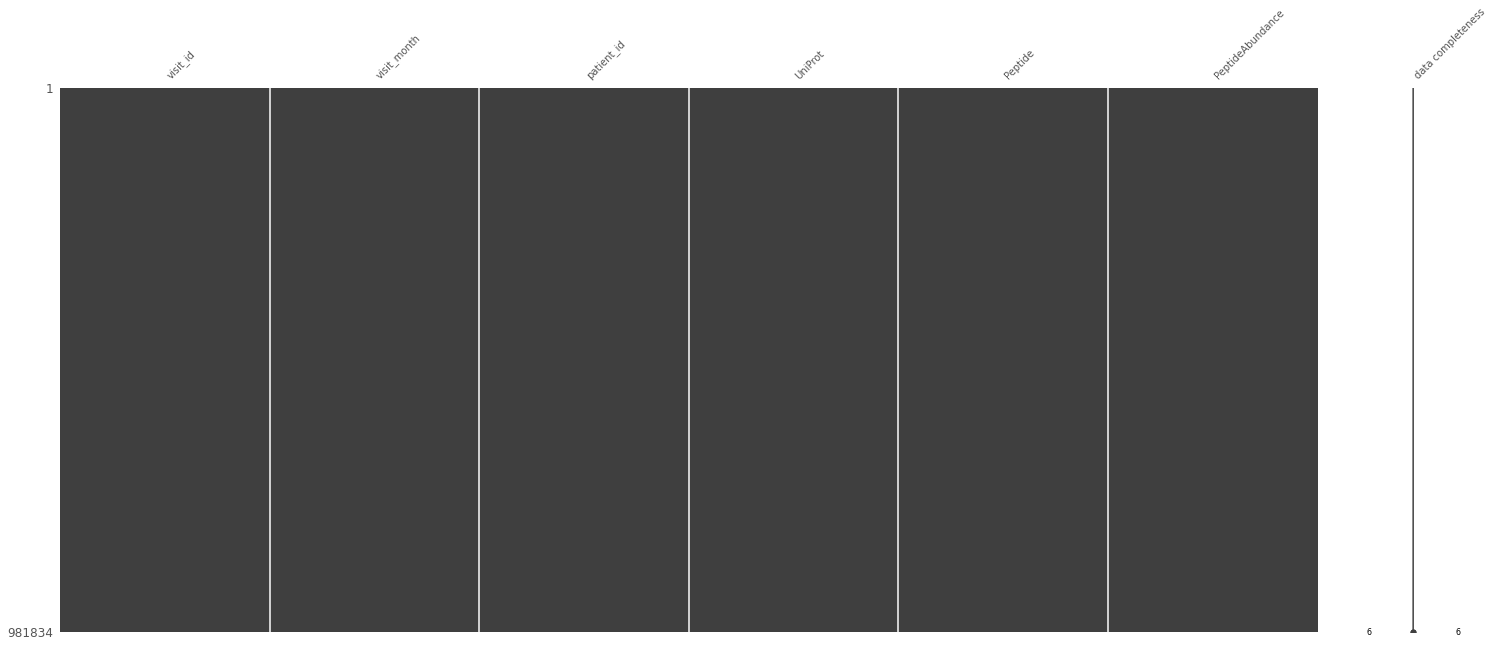

In [30]:
mno.matrix(peptide_data, labels=True, fontsize=10)

In [31]:
print_missing_vals(peptide_data, 6)

                  Total  Percent
visit_id              0      0.0
visit_month           0      0.0
patient_id            0      0.0
UniProt               0      0.0
Peptide               0      0.0
PeptideAbundance      0      0.0


### Correlation

In [32]:
cleaned_clinical.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_medication_Off,upd23b_medication_On
0,55_9,55,9,8.0,9.0,30.0,0.0,0,1
1,55_12,55,12,10.0,10.0,41.0,0.0,0,1
2,55_18,55,18,7.0,13.0,38.0,0.0,0,1
3,55_24,55,24,16.0,9.0,49.0,0.0,0,1
4,55_30,55,30,14.0,13.0,49.0,0.0,0,1


In [33]:
merged_peptide_protein = pd.merge(peptide_data, protein_data, on=['visit_id', 'visit_month', 'patient_id', 'UniProt'])
merged = pd.merge(merged_peptide_protein, cleaned_clinical, on=['visit_id', 'visit_month', 'patient_id'])
merged.head()
merged.to_csv("../data/artificial_data/train_merged.csv")


#### Peptide to Vec

In [34]:
from bio_embeddings.embed import ProtTransT5XLU50Embedder

embedder = ProtTransT5XLU50Embedder()

embedding = embedder.embed("NEQEQPLGQWHLS")
embedding

ModuleNotFoundError: No module named 'allennlp.commands.elmo'